In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
from typing import Sequence

import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.ml.extra_torch_modules import PWLNNFcn
from janelia_core.ml.utils import torch_mod_to_fcn
from janelia_core.ml.utils import torch_devices_memory_usage

from sparse_networks import CenteredBumpFcn
from sparse_networks import FunctionSequenceGenerator
from sparse_networks import plot_2d_f
from sparse_networks import SumOfBumpFcns


## Define objects

## Fitting function

In [3]:
def fit(nn: torch.nn.Module, x: torch.Tensor, y: torch.Tensor, n_its = 1000, lr=.01, batch_size: int = None, 
        enforce_bounds: bool = True, update_int: int = 1000):
    """ Fits a neural network. 
    
    Args:
        x: Input data of shape n_smps*d_in
        
        y: Output data of shape n_smps*1
        
        n_its: The number of iterations to run optimization for
        
        lr: The learning rate to use
        
        enforce_bounds: If true, the center of bump functions will be
        constrained to stay in the unit hypercube
        
        update_int: Interval updates are printed
    
    """
    
    params = nn.parameters()
    
    optimizer = torch.optim.Adam(params = params, lr=lr)
    
    n_smps = x.shape[0]
    if batch_size is None:
        batch_size = n_smps
    
    for i in range(n_its):
        
        # Select samples for this iteration 
        if batch_size != n_smps:
            inds = torch.randperm(n_smps)[1:batch_size]
            batch_x = x[inds, :]
            batch_y = y[inds]
        else:
            batch_x = x
            batch_y = y
        
        optimizer.zero_grad()
        
        y_pred = nn(batch_x)
        er = torch.sum((batch_y - y_pred)**2)/batch_size
        er.backward()
        
        optimizer.step()
        
        if enforce_bounds:
            nn.bound()
        
        if i % update_int == 0:
            er_log = float(er.detach().cpu().numpy())
            print('It ' + str(i) +  ': {:e}'.format(er_log))
    

## Generate ground-truth functions we want to fit

We generate multiple functions - one for each output dimension we want

In [4]:
n_tgt_fcns = 1000

In [5]:
fcn_generators = [FunctionSequenceGenerator(n_bumps = 200, bump_peak_vl_range = [-1, 1], cov_ev_range = [.002, .002])
                  for f_i in range(n_tgt_fcns)]

true_fcns = [g.generate() for g in fcn_generators]

x = np.random.rand(10000,2)
y = [f(x) for f in true_fcns]

x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(np.stack(y).transpose(), dtype=torch.float32)

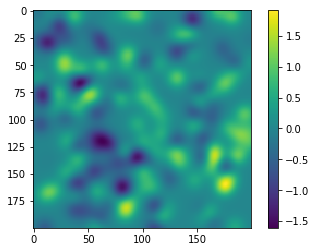

In [6]:
plot_2d_f(true_fcns[999], n_smps_per_dim=200)

## Now fit the function

In [7]:
run_on_gpu = True
n_fcns = 500
k = 5

In [8]:
init_centers = torch.rand(n_fcns, 2)
init_weights = torch.ones(n_fcns, 2, n_tgt_fcns)
init_offsets = torch.zeros(n_fcns, n_tgt_fcns)

In [10]:
fit_f = PWLNNFcn(init_centers=init_centers, init_weights=init_weights, init_offsets=init_offsets, 
                        k=k)

In [11]:
if run_on_gpu:
    fit_f.to('cuda')
    x = x.to('cuda')
    y = y.to('cuda')
else:
    fit_f.to('cpu')
    x = x.to('cpu')
    y = y.to('cpu')

In [12]:
lr = .001
enforce_bounds=True
batch_size = 10000

t0 = time.time()

fit(fit_f, x, y, n_its = 10000, lr=lr, batch_size=batch_size, enforce_bounds=enforce_bounds, update_int=500)
    
t_stop = time.time()

print('Elapsed time: ' + str(t_stop - t0))

It 0: 2.133450e+02
It 500: 5.059369e+01
It 1000: 3.558546e+01
It 1500: 2.671504e+01
It 2000: 2.020376e+01
It 2500: 1.647049e+01
It 3000: 1.357288e+01
It 3500: 1.136260e+01
It 4000: 9.953142e+00
It 4500: 8.796659e+00
It 5000: 8.035984e+00
It 5500: 7.284742e+00
It 6000: 6.805034e+00
It 6500: 6.380180e+00
It 7000: 6.106312e+00
It 7500: 5.882535e+00
It 8000: 5.680708e+00
It 8500: 5.570140e+00
It 9000: 5.462245e+00
It 9500: 5.412922e+00
Elapsed time: 144.30128931999207


In [13]:
fit_f.to('cpu') 
x = x.to('cpu')
y = y.to('cpu')

In [14]:
class torch_plot_fnc(torch.nn.Module):
    
    def __init__(self, m, plot_d): 
        
        super().__init__()
        self.plot_d = plot_d
        self.m = m
        
    def forward(self, x): 
        
        y_full = self.m(x)
        return y_full[:, self.plot_d].squeeze()

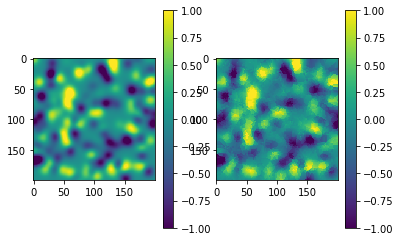

In [15]:
plot_f = 45

plt.subplot(1,2,1)
plot_2d_f(true_fcns[plot_f], n_smps_per_dim=200)
plt.gca().get_images()[0].set_clim(-1,1)
plt.subplot(1,2,2)
plot_2d_f(torch_mod_to_fcn(torch_plot_fnc(fit_f, plot_f)), n_smps_per_dim=200)
plt.gca().get_images()[0].set_clim(-1,1)

In [16]:
max_memory = torch_devices_memory_usage([torch.device('cuda')], 'max_memory_allocated')[0]
max_memory = max_memory/(1024**3)
print('Max memory: ' + str(max_memory) + ' GB')

Max memory: 1.3671250343322754 GB
